# COVET on Spatial Pancreas data  

Perform analysis per donor, consider one object per slide (2 donors) and perform analysis per fov.  

in v4: test in only 1 fov to see if it makes sense

conclusion: it identifies spatially variable regions 

### Pre-requisites

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" # Change to -1 if you want to use CPU!

import warnings
warnings.filterwarnings('ignore')

In [2]:
import scenvi

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
#import colorcet
import sklearn.neighbors
import scipy.sparse
import umap.umap_ as umap
import squidpy as sq

In [4]:
from tqdm import tqdm
from anndata import AnnData
from matplotlib.axes import Axes

In [ ]:
!pip install squidpy

### Data

In [5]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
file   = 'S1_npod_annotation_filtered.h5ad'

adata = sc.read_h5ad(folder+file)
adata

AnnData object with n_obs × n_vars = 108711 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max'
    uns: 'CellTypes_max_colors', 'cell_type_coarse_colors', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_fov'
    layers: 'counts'

In [6]:
adata.layers['counts'].max(), adata.X.max()

(285, 4.715945)

### Subsetting and pre-processing

COVET requires un-logged counts and it doesn't work with adata.X sparse 

In [8]:
adata.X = adata.layers['counts'].toarray()
print(adata.X.max())
sc.pp.normalize_total(adata)
print(adata.X.max())
adata.obs['cell_type'] = adata.obs['CellTypes_max']

285
110.71429


### Compute covet

#### Number of neighbors analysis

In [9]:
N_NEIGHBORS = [8, 15, 30, 50]

In [10]:
for n_neighbors in N_NEIGHBORS:
    sq.gr.spatial_neighbors(
        adata, library_key='fov', coord_type="generic", n_neighs=n_neighbors, key_added=f"spatial-n_neighbors={n_neighbors}",
    )


#### Covet with different neighbors  

Important to compute the covet representation per slide per condition. Unable to deal with the batch effect generated from multiple conditions

In [11]:
NEIGHBORS = [8, 15, 30]

In [13]:
import anndata as ad

adatas_fov = []
for c in adata.obs.fov.cat.categories:
        
    adata_fov = adata[np.isin(adata.obs['fov'],[c])].copy()
             
    for n_neighbors in NEIGHBORS:
        (
            adata_fov.obsm[f"covet-n_neighbors={n_neighbors}"],
            adata_fov.obsm[f"covet_sqrt-n_neighbors={n_neighbors}"],
            adata_fov.uns[f"covet_genes-n_neighbors={n_neighbors}"],
        ) = scenvi.utils.compute_covet(adata_fov, k=n_neighbors, g=64, genes=[], spatial_key='spatial')#, batch_key='fov')
            
    adatas_fov.append(adata_fov)       
    del adata_fov
        
adata = ad.concat(adatas_fov, join='outer',uns_merge='same',axis=0)

**Note:** new in v4: instead of doing the analysis per condition do it per fov 

In [14]:
adatas_fov = []
for c in adata.obs.fov.cat.categories:
    adata_fov = adata[np.isin(adata.obs['fov'],[c])].copy()
    for n_neighbors in NEIGHBORS:
        adata_fov.obsm[f"covet_sqrt_flat-n_neighbors={n_neighbors}"] = np.reshape(
            adata_fov.obsm[f"covet_sqrt-n_neighbors={n_neighbors}"],[adata_fov.shape[0], -1]
        )
    adatas_fov.append(adata_fov)       
    del adata_fov
adata = ad.concat(adatas_fov, join='outer',uns_merge='same',axis=0)

### COVET analysis

In [15]:
from numpy.typing import NDArray
def get_overlap(adata: AnnData, graph_1: str, graph_2: str) -> NDArray:
    neighbors_1 = [row.nonzero()[1] for row in adata.obsp[graph_1]]
    neighbors_2 = [row.nonzero()[1] for row in adata.obsp[graph_2]]

    overlap = [
        np.intersect1d(group_1, group_2, assume_unique=True).size / group_1.size
        for group_1, group_2 in zip(neighbors_1, neighbors_2)
    ]
    return np.array(overlap)

In [15]:
folder

'/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'

In [16]:
adata.write(folder+'s1_covet_rep_per_fov.h5ad')

In [18]:
adata_cond = adata[np.isin(adata.obs['fov'],['12'])].copy()

In [19]:
for n_neighbors in NEIGHBORS:
    sc.pp.neighbors(adata_cond, use_rep=f"covet_sqrt_flat-n_neighbors={n_neighbors}",
                    key_added=f"n_neighbors={n_neighbors}")

In [ ]:
adatas = []
for i in range(len(adatas_cond)):
    print(i)        
    adata_cond = adatas_cond[i].copy()             
    for n_neighbors in NEIGHBORS:
        sc.pp.neighbors(adata_cond, use_rep=f"covet_sqrt_flat-n_neighbors={n_neighbors}",
                        key_added=f"n_neighbors={n_neighbors}")
            
    adatas.append(adata_cond)       
    del adata_cond
        
adatas_cond = ad.concat(adatas, join='outer',uns_merge='same',axis=0,pairwise=True) 

0
1
2
3
4
5


Index(['Run5211_S1'], dtype='object')Index(['ND'], dtype='object')


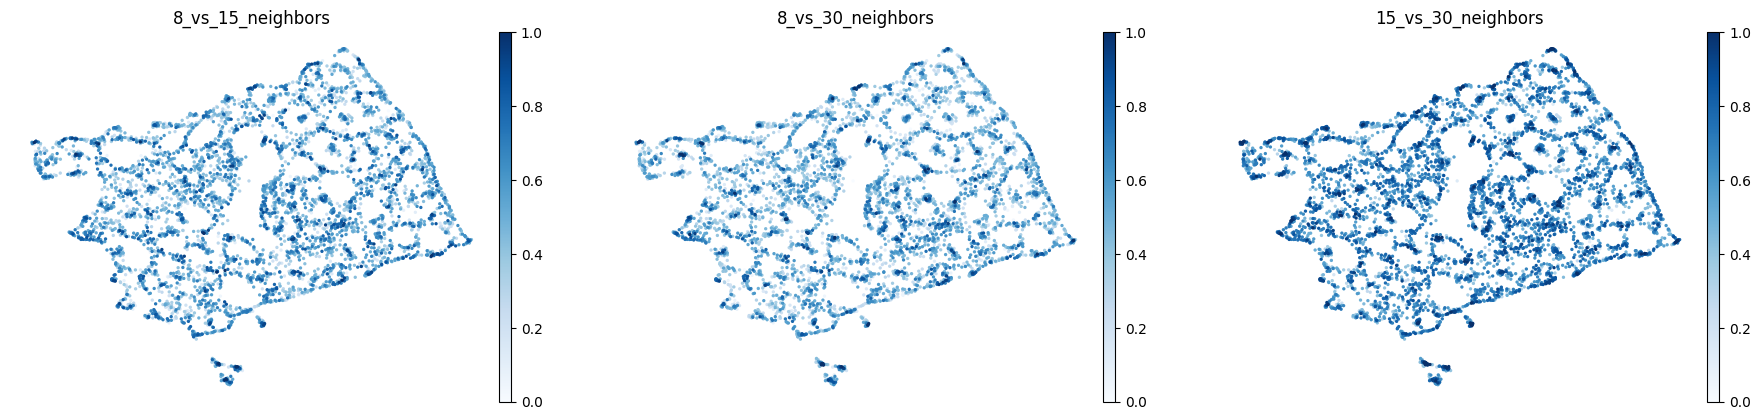

In [22]:
sc.tl.umap(adata_cond, min_dist=0.5,neighbors_key="n_neighbors=30")
        
adata_cond.obs["8_vs_15_neighbors"] = get_overlap(
    adata_cond, graph_1="n_neighbors=8_connectivities", graph_2="n_neighbors=15_connectivities"
)
adata_cond.obs["8_vs_30_neighbors"] = get_overlap(
    adata_cond, graph_1="n_neighbors=8_connectivities", graph_2="n_neighbors=30_connectivities"
)
adata_cond.obs["15_vs_30_neighbors"] = get_overlap(
    adata_cond, graph_1="n_neighbors=15_connectivities", graph_2="n_neighbors=30_connectivities"
)
print(str(adata_cond.obs['slide'].cat.categories.unique())+str(adata_cond.obs['condition'].cat.categories.unique()))
sc.pl.umap(adata_cond, color=["8_vs_15_neighbors","8_vs_30_neighbors","15_vs_30_neighbors"],
            color_map="Blues",frameon=False, ncols=3)

In [ ]:
adatas = []
for i in range(len(adatas_cond)):
    print(i)        
    adata_cond = adatas_cond[i].copy()   
        
    sc.tl.umap(adata_cond, min_dist=0.3,neighbors_key="n_neighbors=30")
        
    adata_cond.obs["8_vs_15_neighbors"] = get_overlap(
        adata_cond, graph_1="n_neighbors=8_connectivities", graph_2="n_neighbors=15_connectivities"
    )
    adata_cond.obs["8_vs_30_neighbors"] = get_overlap(
        adata_cond, graph_1="n_neighbors=8_connectivities", graph_2="n_neighbors=30_connectivities"
    )
    adata_cond.obs["15_vs_30_neighbors"] = get_overlap(
        adata_cond, graph_1="n_neighbors=15_connectivities", graph_2="n_neighbors=30_connectivities"
    )
    print(str(adata_cond.obs['slide'].cat.categories.unique())+str(adata_cond.obs['condition'].cat.categories.unique()))
    sc.pl.umap(adata_cond, color=["8_vs_15_neighbors","8_vs_30_neighbors","15_vs_30_neighbors"],
               color_map="Blues",frameon=False, ncols=3)
        
    adatas.append(adata_cond)       
    del adata_cond
        
adatas_cond = ad.concat(adatas, join='outer',uns_merge='same',axis=0,pairwise=True) 

Index(['Run5211_S1'], dtype='object')Index(['ND'], dtype='object')


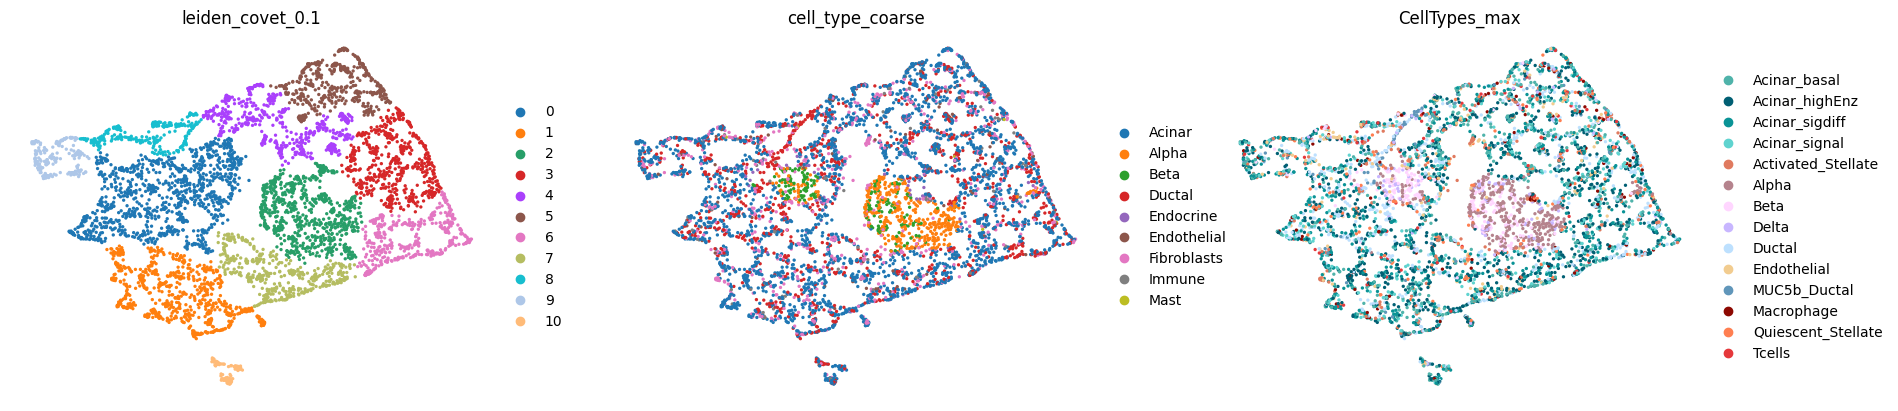

In [23]:
resolutions = [0.1]
for r in resolutions:
    sc.tl.leiden(adata_cond, resolution=r, key_added='leiden_covet_'+str(r),neighbors_key="n_neighbors=30")
        
print(str(adata_cond.obs['slide'].cat.categories.unique())+str(adata_cond.obs['condition'].cat.categories.unique()))
#sc.pl.umap(adata_cond, color=['leiden_covet_0.1', 'leiden_covet_0.3', 'leiden_covet_0.5',
#                   "CellTypes_max",'cell_type_coarse'],ncols=5,frameon=False)
sc.pl.umap(adata_cond, color=['leiden_covet_0.1','cell_type_coarse',"CellTypes_max"],ncols=5,frameon=False)

In [ ]:
resolutions = [0.01]
adatas = []
for i in range(len(adatas_cond)):
    print(i)        
    adata_cond = adatas_cond[i].copy()  
    for r in resolutions:
        sc.tl.leiden(adata_cond, resolution=r, key_added='leiden_covet_'+str(r),neighbors_key="n_neighbors=30")
        
    print(str(adata_cond.obs['slide'].cat.categories.unique())+str(adata_cond.obs['condition'].cat.categories.unique()))
    #sc.pl.umap(adata_cond, color=['leiden_covet_0.1', 'leiden_covet_0.3', 'leiden_covet_0.5',
    #                   "CellTypes_max",'cell_type_coarse'],ncols=5,frameon=False)
    sc.pl.umap(adata_cond, color=['leiden_covet_0.01',"CellTypes_max",'cell_type_coarse'],ncols=5,frameon=False)
        
    adatas.append(adata_cond)       
    del adata_cond
        
adatas_cond = ad.concat(adatas, join='outer',uns_merge='same',axis=0,pairwise=True) 

In [26]:
def plot_relative_abundances(adata, group_by, cell_type_key, **kwargs) -> Axes:

    # Step 1: Group observations by 'condition' and count each 'CellTypes_max' entry
    counts = adata.obs.groupby([group_by, cell_type_key]).size().unstack(fill_value=0)
    
    # Step 2: Calculate relative abundance (proportion) by normalizing counts within each condition
    relative_abundance = counts.div(counts.sum(axis=1), axis=0)
    
    #colors 
    colors = ['#4FB3AA',#'Acinar_basal'
              '#005F73',#'Acinar_highEnz', 
              '#0A9396',#'Acinar_sigdiff', 
              '#5FD3CF',#'Acinar_signal',
              '#e07a5f',#'Activated_Stellate', 
              '#b5838d',#'Alpha', 
              #'#f8ad9d',#'Bcells', 
              '#ffd6ff',#'Beta', 
              '#c8b6ff',#'Delta', 
              '#bde0fe',#'Ductal',
              '#f2cc8f',#'Endothelial', 
              #'#ffa62b',#'LymphEndo', 
              '#6096ba',#'MUC5b_Ductal', 
              '#8d0801',#'Macrophage', 
              #'#4f000b',#'Mast',
              '#ff7f51',#'Quiescent_Stellate', 
              #'#ce4257',#'Schwann', 
              '#e5383b',#'Tcells'
    ]
    
    # Plot a stacked bar chart
    ax = relative_abundance.plot(kind='bar', stacked=True,color=colors)
    
    # Customize the plot (labels, title, etc.)
    plt.xlabel('niche')
    plt.ylabel('Relative abundance')
    #plt.title('Stacked Bar Plot of Counts per Category')
    plt.xticks(rotation=90)
    # Step 3: Position the legend outside the plot
    plt.legend(title='Cell types', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to make room for the legend
    plt.tight_layout()
      
    # Show the plot
    plt.show()

    return ax

In [33]:
counts = adata_cond.obs.groupby(['leiden_covet_0.1', 'CellTypes_max']).size().unstack(fill_value=0)
# Step 2: Calculate relative abundance (proportion) by normalizing counts within each condition
relative_abundance = counts.div(counts.sum(axis=1), axis=0)
relative_abundance

CellTypes_max,Acinar_basal,Acinar_highEnz,Acinar_sigdiff,Acinar_signal,Activated_Stellate,Alpha,Beta,Delta,Ductal,Endothelial,MUC5b_Ductal,Macrophage,Quiescent_Stellate,Tcells
leiden_covet_0.1,,,,,,,,,,,,,,
0,0.060302,0.166834,0.159799,0.089447,0.038191,0.041206,0.090452,0.032161,0.183920,0.036181,0.023116,0.027136,0.035176,0.016080
1,0.144509,0.261561,0.210983,0.091040,0.056358,0.002890,0.004335,0.004335,0.098266,0.026012,0.014451,0.031792,0.031792,0.021676
2,0.023112,0.061633,0.040062,0.023112,0.030817,0.474576,0.169492,0.077042,0.036980,0.012327,0.000000,0.015408,0.029276,0.006163
3,0.135940,0.227188,0.135940,0.108007,0.050279,0.026071,0.007449,0.005587,0.148976,0.039106,0.013035,0.048417,0.040968,0.013035
4,0.177291,0.191235,0.165339,0.069721,0.065737,0.001992,0.011952,0.017928,0.111554,0.061753,0.045817,0.023904,0.029880,0.025896
5,0.151030,0.160183,0.164760,0.089245,0.041190,0.006865,0.011442,0.038902,0.114416,0.050343,0.036613,0.041190,0.045767,0.048055
6,0.128266,0.268409,0.180523,0.095012,0.045131,0.004751,0.000000,0.011876,0.168646,0.026128,0.021378,0.014252,0.019002,0.016627
7,0.136585,0.282927,0.165854,0.075610,0.036585,0.000000,0.002439,0.000000,0.126829,0.056098,0.012195,0.031707,0.056098,0.017073
8,0.060837,0.076046,0.106464,0.064639,0.076046,0.003802,0.034221,0.026616,0.224335,0.091255,0.083650,0.045627,0.064639,0.041825


In [36]:
def define_niches(adata, group_by, cell_type_key):
    
    # Step 1: Group observations by 'condition' and count each 'CellTypes_max' entry
    counts = adata.obs.groupby([group_by, cell_type_key]).size().unstack(fill_value=0)
        
    # Step 2: Calculate relative abundance (proportion) by normalizing counts within each condition
    relative_abundance = counts.div(counts.sum(axis=1), axis=0)
    
    # Define conditions
    endocrine_condition = (relative_abundance[['Alpha', 'Beta', 'Delta']].sum(axis=1) >= 0.5)
    endocrine_exocrine_condition = (
        (relative_abundance[['Alpha', 'Beta', 'Delta']].sum(axis=1) >= 0.1) &
        (relative_abundance[['Acinar_basal', 'Acinar_highEnz', 'Acinar_sigdiff', 'Acinar_signal']].sum(axis=1) >= 0.4) &
        (relative_abundance[['Ductal', 'MUC5b_Ductal']].sum(axis=1) >= 0.2)
    )
    ductal_condition = (relative_abundance[['Ductal', 'MUC5b_Ductal']].sum(axis=1) >= 0.3)
    acinar_condition = (relative_abundance[['Acinar_basal', 'Acinar_highEnz', 'Acinar_sigdiff', 'Acinar_signal']].sum(axis=1) >= 0.6)
    
    # Define choices
    choices = [
        'Endocrine niche',
        'Endocrine Exocrine niche',
        'Ductal niche',
        'Acinar niche'
    ]
    
    # Apply conditions with np.select
    relative_abundance['niche'] = np.select(
        [endocrine_condition, endocrine_exocrine_condition, ductal_condition, acinar_condition],
        choices,
        default='Heterogeneous niche'
    )

    # Map 'niche' values from niche_df to a new 'niche' column in adata.obs
    adata.obs['covet_niche'] = adata.obs[group_by].map(relative_abundance['niche'])

    
    return adata

In [38]:
define_niches(adata_cond, group_by='leiden_covet_0.1',cell_type_key='CellTypes_max')
adata_cond

AnnData object with n_obs × n_vars = 5208 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'cell_type', '8_vs_15_neighbors', '8_vs_30_neighbors', '15_vs_30_neighbors', 'leiden_covet_0.01', 'leiden_covet_0.1', 'covet_niche'
    uns: 'CellTypes_max_colors', 'neighbors', 'pca', 'spatial', 'umap', 'spatial-n_neighbors=8_neighbors', 'spatial-n_neighbors=15_neighbors', 'spatial-n_neighbors=30_neighbors', 'spatial-n_neighbors=50_neighbors', '

In [ ]:
plot_relative_abundances(adata_cond, group_by='leiden_covet_0.1',cell_type_key='CellTypes_max')

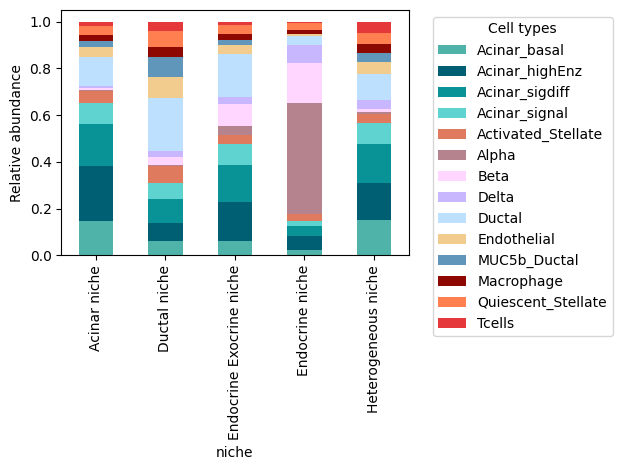

<Axes: xlabel='niche', ylabel='Relative abundance'>

In [40]:
plot_relative_abundances(adata_cond, group_by='covet_niche',cell_type_key='CellTypes_max')

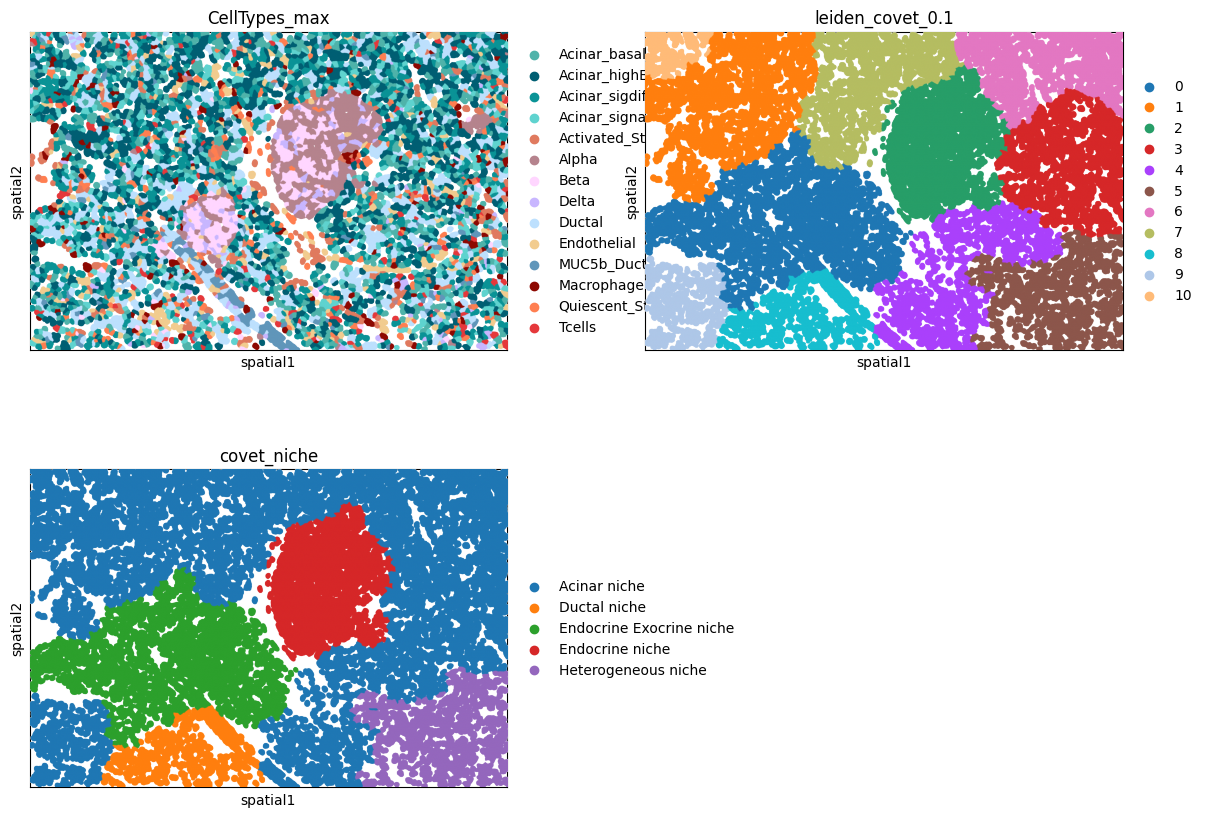

In [39]:
sq.pl.spatial_segment(adata_cond,color=['CellTypes_max','leiden_covet_0.1','covet_niche'],library_id=['12'],
                      library_key='fov', seg_cell_id='cell_ID', img=False,ncols=2)